# Quality assurance and quality control

## WAFS

In [1]:
import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import xarray as xr

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Computer Modern Roman"],
        "axes.grid": False,
        "savefig.dpi": 700,
        "figure.figsize": [8, 6],
        "font.size": 14,
    }
)
plt.style.use(["seaborn-colorblind"])
xr.set_options(display_expand_data=False)

### Single datasets

In [2]:
ds_wind_temp = xr.open_dataset(
    "../../pangeo_tools/wafs/wafs_[wind_temp]_20220630T120000Z_[20220630T210000Z].nc"
)
ds_ice = xr.open_dataset(
    "../../pangeo_tools/wafs/wafs_[ice]_20220630T120000Z_[20220630T210000Z].nc"
)
ds_turb = xr.open_dataset(
    "../../pangeo_tools/wafs/wafs_[turb]_20220630T120000Z_[20220630T210000Z].nc"
)

In [3]:
ds_wind_temp

<xarray.Dataset>
Dimensions:                   (time: 1, lev: 53, lat: 721, lon: 1440)
Coordinates:
  * lev                       (lev) float32 3e+03 4e+03 ... 5.4e+04 5.5e+04
  * lon                       (lon) float32 -180.0 -179.8 -179.5 ... 179.5 179.8
  * lat                       (lat) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
  * time                      (time) datetime64[ns] 2022-06-30T21:00:00
Data variables:
    air_temperature_aviation  (time, lev, lat, lon) float32 ...
    wind_direction_aviation   (time, lev, lat, lon) float32 ...
    wind_speed_aviation       (time, lev, lat, lon) float32 ...
Attributes:
    regrid_method:    bilinear
    title:            WAFS
    institution:      NOAA/NCEP
    version:          0.1.0
    forecast_time:    2022-06-30T21:00:00
    forecast_hour:    21
    batch_timestamp:  2022-06-30T12:00:00

In [4]:
ds_wind_temp.lat

<xarray.DataArray 'lat' (lat: 721)>
-90.0 -89.75 -89.5 -89.25 -89.0 -88.75 ... 88.75 89.0 89.25 89.5 89.75 90.0
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degree_north
    dtype:          float32
    precision:      2
    valid_max:      90
    valid_min:      -90
    description:    
    notes:          [-90, 90]

In [5]:
ds_ice.lat

<xarray.DataArray 'lat' (lat: 721)>
-90.0 -89.75 -89.5 -89.25 -89.0 -88.75 ... 88.75 89.0 89.25 89.5 89.75 90.0
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    units:             degree_north
    standard_name:     latitude
    long_name:         Latitude
    stored_direction:  decreasing
    dtype:             float32
    precision:         2
    valid_max:         90
    valid_min:         -90
    description:       
    notes:             [-90, 90]

In [6]:
ds_turb.lat

<xarray.DataArray 'lat' (lat: 721)>
-90.0 -89.75 -89.5 -89.25 -89.0 -88.75 ... 88.75 89.0 89.25 89.5 89.75 90.0
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    units:             degree_north
    standard_name:     latitude
    long_name:         Latitude
    stored_direction:  decreasing
    dtype:             float32
    precision:         2
    valid_max:         90
    valid_min:         -90
    description:       
    notes:             [-90, 90]

In [7]:
ds_wind_temp.lon

<xarray.DataArray 'lon' (lon: 1440)>
-180.0 -179.8 -179.5 -179.2 -179.0 -178.8 ... 178.8 179.0 179.2 179.5 179.8
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degree_east
    dtype:          float32
    precision:      2
    valid_max:      180
    valid_min:      -180
    description:    
    notes:          [-180, 180]

In [8]:
ds_ice.lon

<xarray.DataArray 'lon' (lon: 1440)>
-180.0 -179.8 -179.5 -179.2 -179.0 -178.8 ... 178.8 179.0 179.2 179.5 179.8
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degree_east
    dtype:          float32
    precision:      2
    valid_max:      180
    valid_min:      -180
    description:    
    notes:          [-180, 180]

In [9]:
ds_turb.lon

<xarray.DataArray 'lon' (lon: 1440)>
-180.0 -179.8 -179.5 -179.2 -179.0 -178.8 ... 178.8 179.0 179.2 179.5 179.8
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degree_east
    dtype:          float32
    precision:      2
    valid_max:      180
    valid_min:      -180
    description:    
    notes:          [-180, 180]

In [10]:
ds_wind_temp.lev

<xarray.DataArray 'lev' (lev: 53)>
3e+03 4e+03 5e+03 6e+03 7e+03 8e+03 ... 5.1e+04 5.2e+04 5.3e+04 5.4e+04 5.5e+04
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
Attributes:
    long_name:      Level of atmosphere
    standard_name:  level
    units:          ft
    valid_min:      0.0
    precision:      1
    dtype:          float32
    description:    Altitude of particular location in the atmosphere
    notes:          _FillValue=-9999

In [11]:
ds_ice.lev

<xarray.DataArray 'lev' (lev: 6)>
6e+03 1e+04 1.4e+04 1.8e+04 2.4e+04 3e+04
Coordinates:
  * lev      (lev) float32 6e+03 1e+04 1.4e+04 1.8e+04 2.4e+04 3e+04
Attributes:
    long_name:      Level of atmosphere
    standard_name:  level
    units:          ft
    valid_min:      0.0
    precision:      1
    dtype:          float32
    description:    Altitude of particular location in the atmosphere
    notes:          _FillValue=-9999

In [12]:
ds_turb.lev

<xarray.DataArray 'lev' (lev: 9)>
1e+04 1.4e+04 1.8e+04 2.4e+04 2.7e+04 3e+04 3.4e+04 3.9e+04 4.5e+04
Coordinates:
  * lev      (lev) float32 1e+04 1.4e+04 1.8e+04 ... 3.4e+04 3.9e+04 4.5e+04
Attributes:
    long_name:      Level of atmosphere
    standard_name:  level
    units:          ft
    valid_min:      0.0
    precision:      1
    dtype:          float32
    description:    Altitude of particular location in the atmosphere
    notes:          _FillValue=-9999

In [13]:
ds_wind_temp.air_temperature_aviation

<xarray.DataArray 'air_temperature_aviation' (time: 1, lev: 53, lat: 721,
                                              lon: 1440)>
[55026720 values with dtype=float32]
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 2022-06-30T21:00:00
Attributes:
    forecast_time:    2022-06-30T21:00:00
    forecast_hour:    21
    batch_timestamp:  2022-06-30T12:00:00
    long_name:        Bulk air temperature
    standard_name:    air_temperature
    units:            deg C
    precision:        1
    dtype:            float32
    description:      Air temperature measured at a particular location in th...
    notes:            _FillValue=-9999

In [14]:
ds_wind_temp.air_temperature_aviation.values[0]

array([[[-40.4, -40.4, -40.4, ..., -40.4, -40.4, -40.4],
        [-39.3, -39.3, -39.3, ..., -39.2, -39.3, -39.3],
        [-38.1, -38.2, -38.2, ..., -38.1, -38.1, -38.1],
        ...,
        [ -3.4,  -3.4,  -3.4, ...,  -3.4,  -3.4,  -3.4],
        [ -2.5,  -2.5,  -2.5, ...,  -2.5,  -2.5,  -2.5],
        [ -1.6,  -1.6,  -1.6, ...,  -1.6,  -1.6,  -1.6]],

       [[-42.1, -42.1, -42.1, ..., -42.1, -42.1, -42.1],
        [-40.9, -40.9, -41. , ..., -40.9, -40.9, -40.9],
        [-39.8, -39.8, -39.8, ..., -39.7, -39.7, -39.8],
        ...,
        [ -4.2,  -4.2,  -4.2, ...,  -4.2,  -4.2,  -4.2],
        [ -3.5,  -3.5,  -3.5, ...,  -3.5,  -3.5,  -3.5],
        [ -2.7,  -2.7,  -2.7, ...,  -2.7,  -2.7,  -2.7]],

       [[-43.7, -43.7, -43.7, ..., -43.7, -43.7, -43.7],
        [-42.6, -42.6, -42.6, ..., -42.5, -42.5, -42.6],
        [-41.4, -41.5, -41.5, ..., -41.4, -41.4, -41.4],
        ...,
        [ -5.1,  -5.1,  -5.1, ...,  -5.1,  -5.1,  -5.1],
        [ -4.4,  -4.4,  -4.4, ...,  -4.4,  -4

In [15]:
ds_wind_temp.wind_speed_aviation

<xarray.DataArray 'wind_speed_aviation' (time: 1, lev: 53, lat: 721, lon: 1440)>
[55026720 values with dtype=float32]
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 2022-06-30T21:00:00
Attributes:
    forecast_time:    2022-06-30T21:00:00
    forecast_hour:    21
    batch_timestamp:  2022-06-30T12:00:00
    long_name:        Wind speed
    standard_name:    wind_speed
    units:            m s-1
    precision:        1
    dtype:            float32
    description:      Sustained wind speed measured at a particular location ...
    notes:            Always >= 0, _FillValue=-9999

In [16]:
ds_wind_temp.wind_speed_aviation.values[0]

array([[[2.8, 2.8, 2.8, ..., 2.8, 2.8, 2.8],
        [3. , 3. , 3. , ..., 3. , 3. , 3. ],
        [3.2, 3.2, 3.2, ..., 3.3, 3.3, 3.2],
        ...,
        [6.9, 6.9, 6.9, ..., 6.9, 6.9, 6.9],
        [6.9, 6.9, 6.9, ..., 6.9, 6.9, 6.9],
        [6.9, 6.9, 6.9, ..., 6.9, 6.9, 6.9]],

       [[2.8, 2.8, 2.8, ..., 2.8, 2.8, 2.8],
        [3. , 3. , 3. , ..., 3. , 3. , 3. ],
        [3.2, 3.2, 3.2, ..., 3.3, 3.3, 3.3],
        ...,
        [7.4, 7.4, 7.4, ..., 7.4, 7.4, 7.4],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.6, 7.6, 7.6, ..., 7.6, 7.6, 7.6]],

       [[2.8, 2.8, 2.8, ..., 2.8, 2.8, 2.8],
        [3. , 3. , 3. , ..., 3. , 3. , 3. ],
        [3.2, 3.2, 3.2, ..., 3.3, 3.3, 3.3],
        ...,
        [7.9, 7.9, 7.9, ..., 7.9, 7.9, 7.9],
        [8.1, 8.1, 8.1, ..., 8.1, 8.1, 8.1],
        [8.2, 8.2, 8.2, ..., 8.2, 8.2, 8.2]],

       ...,

       [[8.3, 8.3, 8.3, ..., 8.3, 8.3, 8.3],
        [8.3, 8.3, 8.3, ..., 8.3, 8.3, 8.3],
        [8.4, 8.4, 8.4, ..., 8.4, 8.4, 8.4

In [17]:
ds_wind_temp.wind_direction_aviation

<xarray.DataArray 'wind_direction_aviation' (time: 1, lev: 53, lat: 721,
                                             lon: 1440)>
[55026720 values with dtype=float32]
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 2022-06-30T21:00:00
Attributes:
    forecast_time:    2022-06-30T21:00:00
    forecast_hour:    21
    batch_timestamp:  2022-06-30T12:00:00
    long_name:        Wind direction (origin)
    standard_name:    wind_from_direction
    units:            degree
    valid_max:        359
    precision:        1
    dtype:            float32
    description:      Meteorological wind direction (defined as where the win...
    notes:            [0, 359], _FillValue=-9999

In [18]:
ds_wind_temp.wind_direction_aviation.values[0]

array([[[ 70.5,  70.5,  70.5, ...,  70.5,  70.5,  70.5],
        [222. , 221.8, 221.6, ..., 222.4, 222.3, 222.2],
        [193.4, 193.3, 193.2, ..., 193.7, 193.6, 193.5],
        ...,
        [153.4, 153.7, 153.9, ..., 152.8, 153. , 153.2],
        [149.2, 149.5, 149.7, ..., 148.5, 148.8, 149. ],
        [325.1, 325.1, 325.1, ..., 325.1, 325.1, 325.1]],

       [[ 70.5,  70.5,  70.5, ...,  70.5,  70.5,  70.5],
        [222. , 221.8, 221.6, ..., 222.4, 222.3, 222.1],
        [193.4, 193.3, 193.2, ..., 193.7, 193.6, 193.5],
        ...,
        [147.9, 148.1, 148.4, ..., 147.2, 147.4, 147.7],
        [143.3, 143.5, 143.8, ..., 142.6, 142.8, 143.1],
        [318.7, 318.7, 318.7, ..., 318.7, 318.7, 318.7]],

       [[ 70.5,  70.5,  70.5, ...,  70.5,  70.5,  70.5],
        [222. , 221.8, 221.6, ..., 222.4, 222.3, 222.1],
        [193.4, 193.3, 193.2, ..., 193.7, 193.6, 193.5],
        ...,
        [142.3, 142.6, 142.8, ..., 141.6, 141.8, 142.1],
        [137.4, 137.6, 137.9, ..., 136.6, 136

In [19]:
ds_ice.icing_severity_index_aviation

<xarray.DataArray 'icing_severity_index_aviation' (time: 1, lev: 6, lat: 721,
                                                   lon: 1440)>
[6229440 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lev      (lev) float32 6e+03 1e+04 1.4e+04 1.8e+04 2.4e+04 3e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 2022-06-30T21:00:00
Attributes:
    forecast_time:    2022-06-30T21:00:00
    forecast_hour:    21
    batch_timestamp:  2022-06-30T12:00:00
    long_name:        Icing severity index
    standard_name:    icing_severity_index_aviation
    units:            index (number)
    valid_min:        -1
    valid_max:        4
    precision:        0
    dtype:            float32
    description:      A numerical index value from -1 to 4 that specifies the...
    notes:            Always >= -1 and <=4 and _FillValue=-9999

In [20]:
ds_turb.eddy_dissipation_rate_aviation

<xarray.DataArray 'eddy_dissipation_rate_aviation' (time: 1, lev: 9, lat: 721,
                                                    lon: 1440)>
[9344160 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lev      (lev) float32 1e+04 1.4e+04 1.8e+04 ... 3.4e+04 3.9e+04 4.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 2022-06-30T21:00:00
Attributes:
    forecast_time:    2022-06-30T21:00:00
    forecast_hour:    21
    batch_timestamp:  2022-06-30T12:00:00
    long_name:        Eddy dissipation rate
    standard_name:    eddy_dissipation_rate_aviation
    units:            m2/3 s-1
    valid_min:        0.0
    valid_max:        1.0
    precision:        3
    dtype:            float32
    description:      Turbulence severity field measured at a particular loca...
    notes:            _FillValue=-9999

In [21]:
ds_turb.eddy_dissipation_rate_aviation.values[0]

array([[[0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
        [0.03, 0.03, 0.03, ..., 0.04, 0.04, 0.04],
        [0.03, 0.03, 0.03, ..., 0.04, 0.03, 0.03],
        ...,
        [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
        [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
        [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03]],

       [[0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
        [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
        [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
        ...,
        [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
        [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
        [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04]],

       [[0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
        [0.04, 0.04, 0.04, ..., 0.05, 0.04, 0.04],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        ...,
        [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05]],

       ...,

       [[0.03, 0.03, 0.0

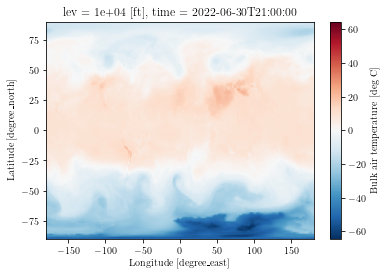

In [22]:
ds_wind_temp["air_temperature_aviation"].sel(lev=10000).plot();

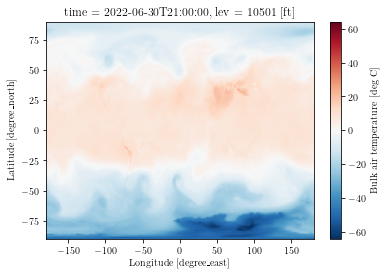

In [23]:
ds_wind_temp["air_temperature_aviation"].interp(
    lev=10501, kwargs={"fill_value": "extrapolate"}
).plot();

In [24]:
colors = {
    "icing_severity_index_aviation": [
        "#e06666",
        "#ffffff",
        "#eff3ff",
        "#bdd7e7",
        "#6baed6",
        "#2171b5",
    ],
    "eddy_dissipation_rate_aviation": [
        "#ffffff",
        "#ffffcc",
        "#ffeda0",
        "#fed976",
        "#feb24c",
        "#fd8d3c",
        "#fc4e2a",
        "#e31a1c",
        "#bd0026",
        "#800026",
    ],
}
levels = {
    "icing_severity_index_aviation": range(-1, 6),
    "eddy_dissipation_rate_aviation": np.linspace(0, 1.0, 11),
}

In [25]:
variable = "icing_severity_index_aviation"

In [26]:
ds_ice.lev.values

array([ 6000., 10000., 14000., 18000., 24000., 30000.], dtype=float32)

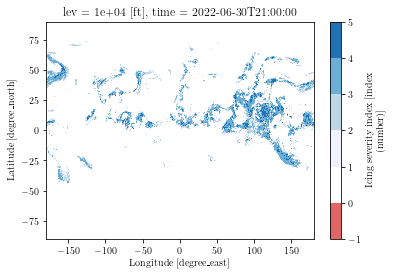

In [27]:
ds_ice[variable].sel(lev=10000).plot(levels=levels[variable], colors=colors[variable]);

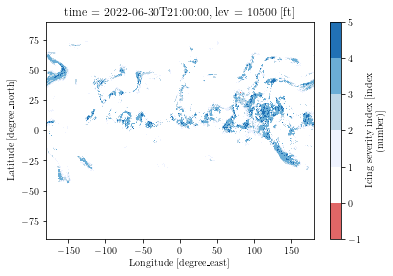

In [28]:
ds_ice[variable].interp(lev=10500, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

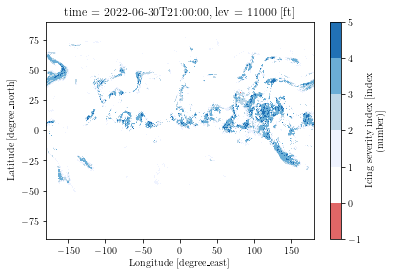

In [29]:
ds_ice[variable].interp(lev=11000, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

In [30]:
variable = "eddy_dissipation_rate_aviation"

In [31]:
ds_turb.lev.values

array([10000., 14000., 18000., 24000., 27000., 30000., 34000., 39000.,
       45000.], dtype=float32)

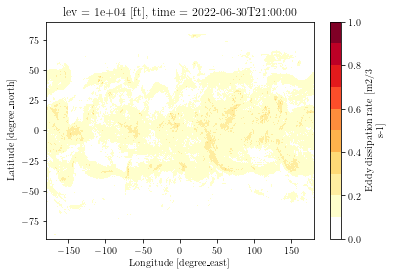

In [32]:
ds_turb[variable].sel(lev=10000).plot(levels=levels[variable], colors=colors[variable]);

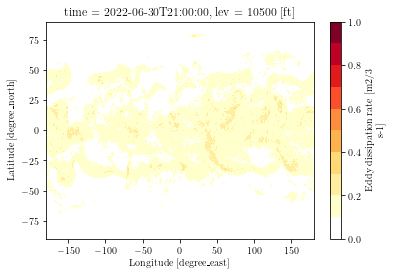

In [33]:
ds_turb[variable].interp(lev=10500, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

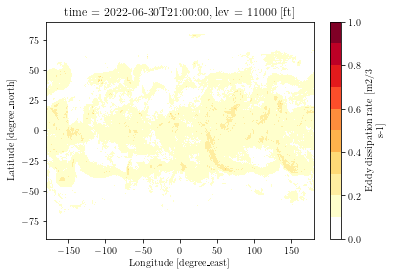

In [34]:
ds_turb[variable].interp(lev=11000, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

In [35]:
variables = set(ds_wind_temp.data_vars) | set(ds_ice.data_vars) | set(ds_turb.data_vars)

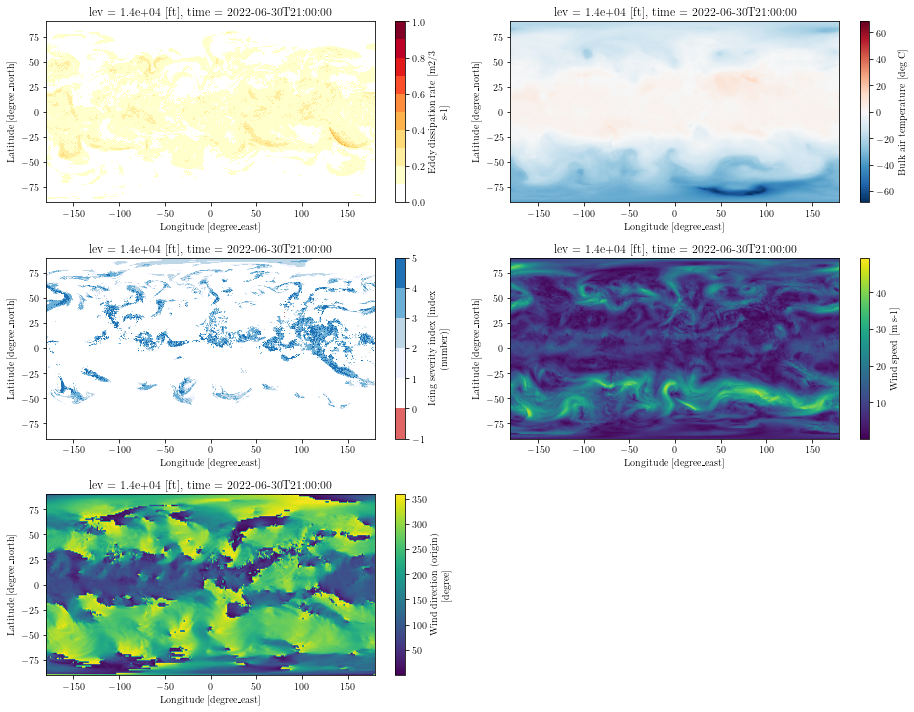

In [36]:
fig = plt.figure(1, figsize=(13, 10))
gs = gridspec.GridSpec(3, 2)

for index, variable in enumerate(variables):
    ax = fig.add_subplot(gs[index])
    if variable == "icing_severity_index_aviation":
        ds_ice[variable].sel(lev=14000).plot(
            ax=ax, levels=levels[variable], colors=colors[variable]
        )
    elif variable == "eddy_dissipation_rate_aviation":
        ds_turb[variable].sel(lev=14000).plot(
            ax=ax, levels=levels[variable], colors=colors[variable]
        )
    else:
        ds_wind_temp[variable].sel(lev=14000).plot(ax=ax)

plt.tight_layout()
# plt.savefig('wafs_20220630T150000Z.png', facecolor="white", dpi=300, bbox_inches="tight")
plt.show()

### Merged datasets

In [43]:
wafs_files = glob.glob("../../pangeo_tools/wafs/wafs_*20220630T*.nc")

In [44]:
wafs_files

['../../pangeo_tools/wafs/wafs_[ice]_20220630T120000Z_[20220630T180000Z].nc',
 '../../pangeo_tools/wafs/wafs_[turb]_20220630T120000Z_[20220630T180000Z].nc',
 '../../pangeo_tools/wafs/wafs_[ice]_20220630T120000Z_[20220630T210000Z].nc',
 '../../pangeo_tools/wafs/wafs_[turb]_20220630T120000Z_[20220630T210000Z].nc',
 '../../pangeo_tools/wafs/wafs_[wind_temp]_20220630T120000Z_[20220630T210000Z].nc',
 '../../pangeo_tools/wafs/wafs_[wind_temp]_20220630T120000Z_[20220630T180000Z].nc']

In [46]:
datasets = {}

for variable in ["wind_temp", "ice", "turb"]:
    wafs_files_variable = sorted([file for file in wafs_files if variable in file])
    datasets_variable = [
        xr.open_dataset(file) for file in wafs_files_variable
    ]
    ds_combined_variable = xr.combine_by_coords(
        datasets_variable, combine_attrs="drop_conflicts"
    )
    datasets[variable] = ds_combined_variable

In [47]:
datasets

{'wind_temp': <xarray.Dataset>
 Dimensions:                   (time: 2, lev: 53, lat: 721, lon: 1440)
 Coordinates:
   * lev                       (lev) float32 3e+03 4e+03 ... 5.4e+04 5.5e+04
   * lon                       (lon) float32 -180.0 -179.8 -179.5 ... 179.5 179.8
   * lat                       (lat) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
   * time                      (time) datetime64[ns] 2022-06-30T18:00:00 2022-...
 Data variables:
     air_temperature_aviation  (time, lev, lat, lon) float32 -42.6 ... -41.9
     wind_direction_aviation   (time, lev, lat, lon) float32 74.9 74.9 ... 295.8
     wind_speed_aviation       (time, lev, lat, lon) float32 2.9 2.9 ... 7.6 7.6
 Attributes:
     regrid_method:    bilinear
     title:            WAFS
     institution:      NOAA/NCEP
     version:          0.1.0
     batch_timestamp:  2022-06-30T12:00:00,
 'ice': <xarray.Dataset>
 Dimensions:                        (lat: 721, lev: 6, lon: 1440, time: 2)
 Coordinates:
   * lat       

In [48]:
datasets["wind_temp"]["air_temperature_aviation"]

<xarray.DataArray 'air_temperature_aviation' (time: 2, lev: 53, lat: 721,
                                              lon: 1440)>
-42.6 -42.6 -42.6 -42.6 -42.6 -42.6 ... -41.9 -41.9 -41.9 -41.9 -41.9 -41.9
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 2022-06-30T18:00:00 2022-06-30T21:00:00
Attributes:
    batch_timestamp:  2022-06-30T12:00:00
    long_name:        Bulk air temperature
    standard_name:    air_temperature
    units:            deg C
    precision:        1
    dtype:            float32
    description:      Air temperature measured at a particular location in th...
    notes:            _FillValue=-9999

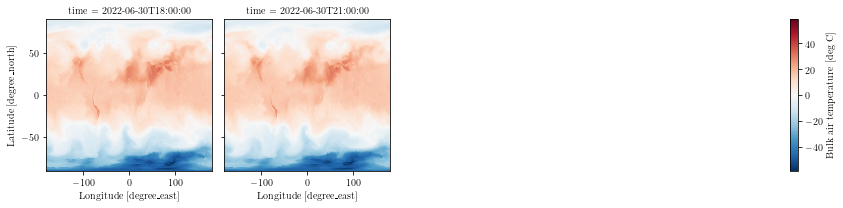

In [49]:
datasets["wind_temp"]["air_temperature_aviation"].isel(lev=3).plot(
    col="time",
    col_wrap=4,
);

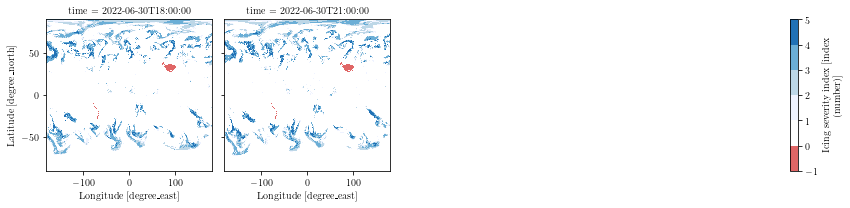

In [50]:
datasets["ice"]["icing_severity_index_aviation"].isel(lev=3).plot(
    col="time",
    col_wrap=4,
    levels=levels["icing_severity_index_aviation"],
    colors=colors["icing_severity_index_aviation"],
);

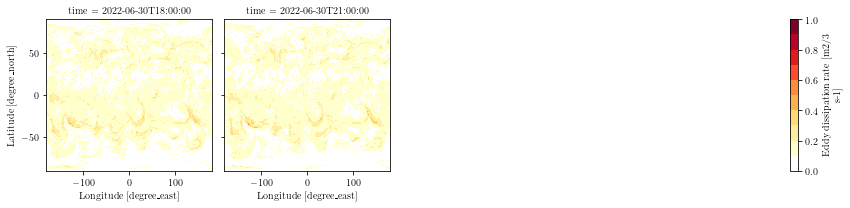

In [51]:
datasets["turb"]["eddy_dissipation_rate_aviation"].isel(lev=3).plot(
    col="time",
    col_wrap=4,
    levels=levels["eddy_dissipation_rate_aviation"],
    colors=colors["eddy_dissipation_rate_aviation"],
);